In [166]:
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.widgets import *
from fastai.vision.all import *
# import gradio as gr
import os, shutil
import time
import requests
import json
!pip install azure-cognitiveservices-search-imagesearch

In [ ]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

def search_images_bing(key, term, min_sz=128, max_images=400):    
     params = {'q':term, 'count':max_images, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [167]:
URL = 'https://dog.ceo/api/breeds/list/all'

In [174]:
# def search_images(term, max_images=300):
#     url = 'https://duckduckgo.com/'
#     res = urlread(url,data={'q':term})
#     searchObj = re.search(r'vqd=([\d-]+)\&', res)
#     requestUrl = url + 'i.js'
#     params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
#     urls,data = set(),{'next':1}
#     while len(urls)<max_images and 'next' in data:
#         data = urljson(requestUrl,data=params)
#         urls.update(L(data['results']).itemgot('image'))
#         requestUrl = url + data['next']
#         time.sleep(0.2)
#     return L(urls)[:max_images]

In [ ]:
result = requests.get(url = URL).json()
searchText = [val for val in result['message']]

In [ ]:
path = Path('Dog_Types')

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '53249801a3224c86b8964343bc1cdc23')

In [ ]:
if not path.exists():
    path.mkdir()
else:
    folder = 'Dog_Types'
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
for o in searchText:
    try:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        results = search_images_bing(key, f'{o} photo')
        download_images(dest, urls=results.attrgot('contentUrl'))
    except shutil.SameFileError:
        pass

In [175]:
# result = requests.get(url = URL).json()
# searchText = [val for val in result['message']]
# path = Path('Dog_Types')
# if not path.exists():
#     path.mkdir()
# else:
#     folder = 'Dog_Types'
#     for filename in os.listdir(folder):
#         file_path = os.path.join(folder, filename)
#         try:
#             if os.path.isfile(file_path) or os.path.islink(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 shutil.rmtree(file_path)
#         except Exception as e:
#             print('Failed to delete %s. Reason: %s' % (file_path, e))
            
# for o in searchText:
#     try:
#        dest = (path/o)
#        dest.mkdir(exist_ok=True, parents=True)
#        download_images(dest, urls=search_images(f'{o} photo'))
#        resize_images(path/o, max_size=400, dest=path/o)
#     except shutil.SameFileError:
#        pass

/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

In [134]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#12) [None,None,None,None,None,None,None,None,None,None...]

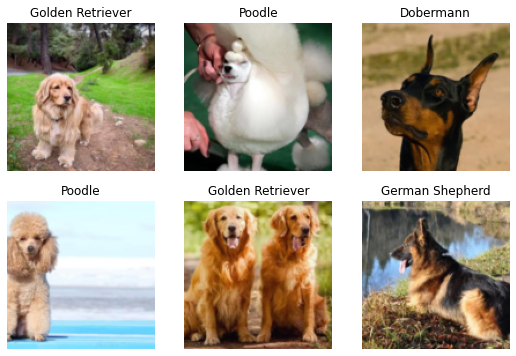

In [135]:
dataloaders = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
).dataloaders(path)

dataloaders.show_batch(max_n=6)

In [136]:
# dls = dataloaders.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())
# dataloaders = dls.dataloaders(path)

In [137]:
learn = vision_learner(dataloaders, resnet18, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.633293,0.298591,0.078431,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.348708,0.276052,0.104575,00:03
1,0.267458,0.290663,0.098039,00:03
2,0.230557,0.277162,0.084967,00:03
3,0.185783,0.245893,0.078431,00:03
4,0.149393,0.223328,0.071895,00:03
5,0.119218,0.218533,0.065359,00:03
6,0.105036,0.159726,0.052288,00:03
7,0.086522,0.154057,0.052288,00:03
8,0.072400,0.163214,0.058824,00:03
9,0.060892,0.180490,0.052288,00:03


In [138]:
learn.export('dogIdentifierModel.pkl')

In [41]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [126]:
learn_inf = load_learner('dogIdentifierModel.pkl')

In [127]:
btn_upload = widgets.FileUpload()

In [128]:
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [129]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [130]:
btn_upload.observe(on_data_change, names=['data'])

In [132]:
display(VBox([widgets.Label('Input a picture of a dog:'), btn_upload, out_pl, lbl_pred]))

In [ ]:
r = requests.get(url = URL)

In [ ]:
r

<Response [200]>

In [ ]:
result = r.json()
result = requests.get(url = URL).json()
dogSearch = [val for val in result['message']]